In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msn
import re
import warnings
import dill
import os
import shap

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.linear_model import Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor

In [3]:
warnings.simplefilter('ignore')

# Подготовка данных

## Загрузка данных

In [73]:
pd.set_option('display.max_columns', None)
data = pd.read_csv(f'data/sold_flats_2020-09-30.csv')
data

,id,status,city_id,district_id,street_id,price,date_sold,sold_price,metro_station_id,flat_on_floor,floor_num,floors_cnt,rooms_cnt,bedrooms_cnt,building_year,area_total,area_live,area_kitchen,area_balcony,builder_id,type,two_levels,levels_count,bathroom,bathrooms_cnt,plate,windows,territory,keep,komunal_cost,series_id,wall_id,balcon,loggia,ceiling_height,closed_yard,longitude,latitude
0,86668,sold,23,12440,353,4980.0,2014-05-16,4880.0,0.0,0,5.0,9.0,3.0,0.0,1989.0,62.0,0.0,8.0,0,0,flat,no,1,unite,NaN,electric,plastic,"parking,closed,elevator",cosmetic,NaN,46.0,11.0,yes_balcon,0,0.00,NaN,65.552498,57.143242
1,87951,sold,23,5279,263,2550.0,2014-02-17,2550.0,0.0,0,5.0,10.0,1.0,0.0,2008.0,40.0,0.0,8.0,0,0,flat,no,1,separate,NaN,electric,wood,"parking,guest_parking,yard_opened,elevator",well_black,1000,50.0,12.0,yes_balcon,0,0.00,NaN,65.567250,57.110282
2,90703,sold,23,588,339,2200.0,2014-07-04,2200.0,0.0,0,5.0,5.0,2.0,0.0,1969.0,44.0,0.0,6.0,0,0,flat,no,1,separate,NaN,NaN,plastic,"parking,yard_opened,without_elevator",cosmetic,NaN,45.0,12.0,yes_balcon,0,0.00,NaN,65.593887,57.147141
3,92948,sold,23,139,546,650.0,2014-09-03,650.0,0.0,0,1.0,4.0,2.0,0.0,1960.0,42.0,26.7,6.0,0,0,flat,no,1,separate,NaN,no_plate,plastic,"parking,guest_parking,yard_opened,without_elev...",need,NaN,79.0,11.0,no_balcon,0,2.50,NaN,65.518670,57.144386
4,102940,sold,23,5279,263,3300.0,2017-11-09,3300.0,0.0,0,1.0,10.0,3.0,3.0,2007.0,65.0,38.0,12.0,4,0,flat,no,1,separate,2.0,electric,plastic,"kolyasochnaya,parking,yard_opened,elevator",good,NaN,50.0,12.0,loggia,0,2.53,NaN,65.568459,57.113392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71756,1943190,sold,45,1063,3396,800.0,2017-12-30,550.0,0.0,0,1.0,2.0,1.0,0.0,1946.0,17.7,0.0,0.0,NaN,0,room,no,1,unite,0.0,gas,wood,"yard_opened,parking,without_elevator",need,NaN,45.0,14.0,no_balcon,0,2.50,NaN,60.627604,56.886927
71757,1943221,sold,748,12307,55431,1900.0,2017-12-27,1900.0,0.0,0,8.0,12.0,1.0,1.0,2016.0,33.0,0.0,0.0,NaN,0,flat,no,1,unite,2.0,NaN,plastic,"yard_opened,parking,guest_parking,elevator",good,NaN,1600.0,14.0,yes_balcon,0,2.50,NaN,37.340514,44.891338
71758,1944254,sold,259,20943,83118,2250.0,2017-12-29,2250.0,0.0,0,5.0,5.0,4.0,0.0,0.0,62.0,0.0,0.0,NaN,0,flat,no,1,separate,2.0,NaN,plastic,"yard_opened,parking,without_elevator",cosmetic,NaN,49.0,11.0,yes_balcon,0,2.50,NaN,NaN,NaN
71759,1945163,sold,220,4107,29382,2000.0,2017-12-28,1800.0,0.0,0,2.0,5.0,4.0,0.0,1979.0,62.0,45.0,6.0,NaN,0,flat,no,1,separate,2.0,NaN,plastic,"child_place,parking,closed,yard_opened,without...",cosmetic,NaN,45.0,12.0,no_balcon,0,2.50,NaN,86.160831,55.352140


In [74]:
init_shape = data.shape

In [75]:
# Вывод количетсва уникальных элементов в признаках
pd.DataFrame({
    'feature': data.columns,
    'n_unique': [len(data[col].unique()) for col in data]
}).sort_values(['n_unique'], ignore_index=True)

,feature,n_unique
0,status,1
1,loggia,1
2,two_levels,3
3,closed_yard,3
4,levels_count,4
5,windows,5
6,bathrooms_cnt,6
7,type,6
8,keep,8
9,plate,9


1. В признаках status и loggia всего по одному уникальному элементу
2. В признаке id число уникальных элементов равно числу объектов в датасете
3. В условиях задачи предлагается игнорировать признак builder_id

Указанные признаки необходимо удалить.

In [76]:
data.drop(columns=['id', 'status', 'loggia', 'builder_id'], inplace=True)

In [77]:
# Отбросим дубликаты
data.drop_duplicates(inplace=True)

In [78]:
# Вывод типов данных признаков
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71758 entries, 0 to 71760
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city_id           71758 non-null  int64  
 1   district_id       71758 non-null  int64  
 2   street_id         71758 non-null  int64  
 3   price             71748 non-null  float64
 4   date_sold         71758 non-null  object 
 5   sold_price        71618 non-null  float64
 6   metro_station_id  71753 non-null  float64
 7   flat_on_floor     71758 non-null  int64  
 8   floor_num         71752 non-null  float64
 9   floors_cnt        71752 non-null  float64
 10  rooms_cnt         71476 non-null  float64
 11  bedrooms_cnt      71012 non-null  float64
 12  building_year     70165 non-null  float64
 13  area_total        71755 non-null  float64
 14  area_live         71755 non-null  float64
 15  area_kitchen      71755 non-null  float64
 16  area_balcony      57390 non-null  object

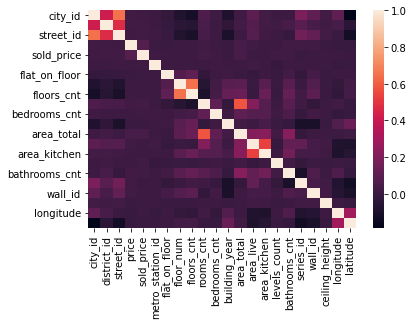

In [79]:
# Посмотрим на корреляцию признаков
sns.heatmap(data.corr());

В данных нет признаков с линейной корреляцией близкой к 1

## Преобразование типов данных

1. Признак date_sold имеет тип данных object, его преобразуем в формат даты и вытащим год продажи
2. Некоторые целочисленные данные имеют тип данных float. Их нужно преобразовать к целочисленному типу
3. Признак area_balcony имеет тип данных object, его нужно преобразовать к вещественному типу данных.
4. Признак territory необходимо разбить на несколько признаков

In [80]:
# Преобзование даты продажи к типу datetime
data['date_sold'] = pd.to_datetime(data['date_sold'])
data['year_sold'] = data['date_sold'].dt.year
data.drop(columns=['date_sold'], inplace=True)

# Преобразование целочисленных данных к целочисленному типу
cols_to_int = [
    'metro_station_id',
    'floor_num',
    'floors_cnt',
    'rooms_cnt',
    'bedrooms_cnt',
    'building_year',
    'bathrooms_cnt',
    'series_id',
    'wall_id'
]
data[cols_to_int] = data[cols_to_int].astype(pd.Int64Dtype())

In [81]:
# Выведем уникальные значения в area_balcony
data['area_balcony'].unique()

array(['0', '4', '6.8', '3', '7.6', '3.3', '2.7', '4.5', '18', '6', '1.9',
       '2.4', '5', '10.8', '10', '9', '3.65', nan, '9.8', '-3,9', '4.4',
       '3.1', '2.75', '3.5', '5.4', '5.1', '7.2', '2.6', '5.2', '3.8',
       '4.1', '6.5', '2.9', '4.3', '4.6', '10.9', '1', '15', '4.17',
       '2.3', '7.4', '19.4', '2.8', '7', '6.2', '8', '5.5', '3.6', '4.77',
       '3.4', '8.2', '2', '6.1', '1.5', '4.2', '1.6', '6.6', '1.4', '1.1',
       '5.7', '11.8', '3.2', '0.8', '8.8', '11', '4.7', '5.3', '2.1',
       '3.7', '7.5', '8.5', '11.6', '3.34', '7.17', '4.62', '4.85', '7.8',
       '1.8', '6.4', '2.5', '1.3', '5.8', '2.2', '6.03', '4.23', '4.24',
       '0.6', '0.9', '6.11', '6.7', '1.2', '8.4', '6.3', '3.9', '5.6',
       '11.9', '10.4', '2.73', '6.9', '7.7', '1.45', '7.9', '10.2', '12',
       '17', '7.3', '3.74', '18.8', '4.8', '-0', '8.04', '3.91', '1.7',
       '8.6', '3.21', '9.1', '3.89', '7.49', '0.7', '2.89', '6.69', '5.9',
       '3.03', '9.4', '8.3', '8.15', '7.1', '3.13', 

Из значений признака area_balcony извлечем первое вхождение вещественного числа

In [82]:
data['area_balcony'] = data['area_balcony'].astype(str).apply(
    lambda d: re.search('\d+[.,]?\d*', d).group() if re.search('\d+[.,]?\d*', d) else np.nan)
data['area_balcony'] = data['area_balcony'].str.replace(',', '.').astype(float)

Разобьем признак terrytory на несколько бинарных признаков по наличию объектов на территории

In [83]:
data_ter = sum([i.split(',') for i in data['territory'].dropna().unique()], [])
data_ter = set(data_ter)
for s in data_ter:
    ind = data['territory'].isna()
    data[s] = data['territory'][~ind].apply(lambda d: s in d if d else np.nan)
    data[s] = data[s].astype(bool)
    data[s] = data[s].astype(pd.Int64Dtype())
data.drop(columns=['territory'], inplace=True)

In [84]:
# Вывод итоговых типов данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71758 entries, 0 to 71760
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city_id             71758 non-null  int64  
 1   district_id         71758 non-null  int64  
 2   street_id           71758 non-null  int64  
 3   price               71748 non-null  float64
 4   sold_price          71618 non-null  float64
 5   metro_station_id    71753 non-null  Int64  
 6   flat_on_floor       71758 non-null  int64  
 7   floor_num           71752 non-null  Int64  
 8   floors_cnt          71752 non-null  Int64  
 9   rooms_cnt           71476 non-null  Int64  
 10  bedrooms_cnt        71012 non-null  Int64  
 11  building_year       70165 non-null  Int64  
 12  area_total          71755 non-null  float64
 13  area_live           71755 non-null  float64
 14  area_kitchen        71755 non-null  float64
 15  area_balcony        57361 non-null  float64
 16  type

## Выбор целевой переменной

В данной задаче объекты недвижимости будем оценивать по стоимости объекта, в качестве целевого признака подойдет price или sold_price

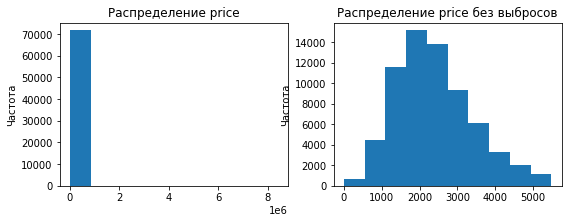

Всего объектов - 71758, без выбросов - 67640


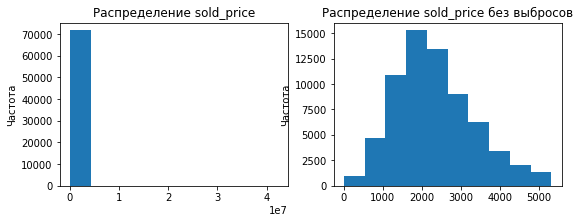

Всего объектов - 71758, без выбросов - 67417


In [85]:
for col in ['price', 'sold_price']:
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(9, 3))
    ax1.hist(data[col])
    ax1.set_title(f'Распределение {col}')
    ax1.set_ylabel('Частота')

    q25, q75 = data[col].quantile([0.25, 0.75])
    iqi = (q25 - 1.5*(q75-q25), q75 + 1.5*(q75-q25))
    ind = (data[col] >= iqi[0]) & (data[col] <= iqi[1])
    ax2.hist(data[col][ind])
    ax2.set_title(f'Распределение {col} без выбросов')
    ax2.set_ylabel('Частота')
    plt.show()
    print(f'Всего объектов - {len(data[col])}, без выбросов - {ind.sum()}')

В целевой переменной есть аномально высокие значения. Отбросим часть объектов, которые не попадают в межквартильный интервал, чтобы лучше предсказывать стоимость основной группы объектов

In [87]:
for col in ['price', 'sold_price']:
    q25, q75 = data[col].quantile([0.25, 0.75])
    iqi = (q25 - 1.5*(q75-q25), q75 + 1.5*(q75-q25))
    ind = (data[col] >= iqi[0]) & (data[col] <= iqi[1])
    data = data[ind]

print(f'Без аномальных объектов осталось {round(data.shape[0]/init_shape[0]*100)} % данных от исходных')

Без аномальных объектов осталось 92 % данных от исходных


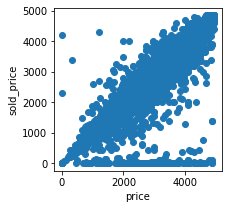

Коэффициент линейной корреляции между признаками price и sold_price: 0.974914716390676


In [88]:
plt.figure(figsize=(3, 3))
plt.scatter(data['price'], data['sold_price'])
plt.xlabel('price')
plt.ylabel('sold_price')
plt.show()
print(f"Коэффициент линейной корреляции между признаками price и sold_price: {data['price'].corr(data['sold_price'])}")

In [89]:
data[['price', 'sold_price']].describe().style.format('{:.0f}')

,price,sold_price
count,66075,66075
mean,2328,2274
std,950,946
min,0,0
25%,1630,1590
50%,2200,2170
75%,2950,2900
max,4950,4860


После обработки признаков price и sold_price их статистические характеристики похожи. Выберем в качестве целевой переменной price, а признак sold_price отбросим

In [90]:
data.drop(columns=['sold_price'], inplace=True)

## Обработка пустых значений

Процентное количество пропусков:



closed_yard           95.694287
komunal_cost          89.832766
plate                 53.982596
bathrooms_cnt         43.918275
area_balcony          19.785093
latitude               8.720393
longitude              8.720393
building_year          2.221718
bedrooms_cnt           1.091184
rooms_cnt              0.423761
series_id              0.295119
metro_station_id       0.003027
keep                   0.003027
floors_cnt             0.001513
floor_num              0.001513
wall_id                0.001513
yard_barrier           0.000000
dog_yard               0.000000
cargo_elevator         0.000000
kolyasochnaya          0.000000
closed                 0.000000
yard_opened            0.000000
without_elevator       0.000000
garage_parking         0.000000
yard_gate              0.000000
semisubway_parking     0.000000
yard_security          0.000000
guest_parking          0.000000
elevator               0.000000
parking                0.000000
video_monitoring       0.000000
no_parki

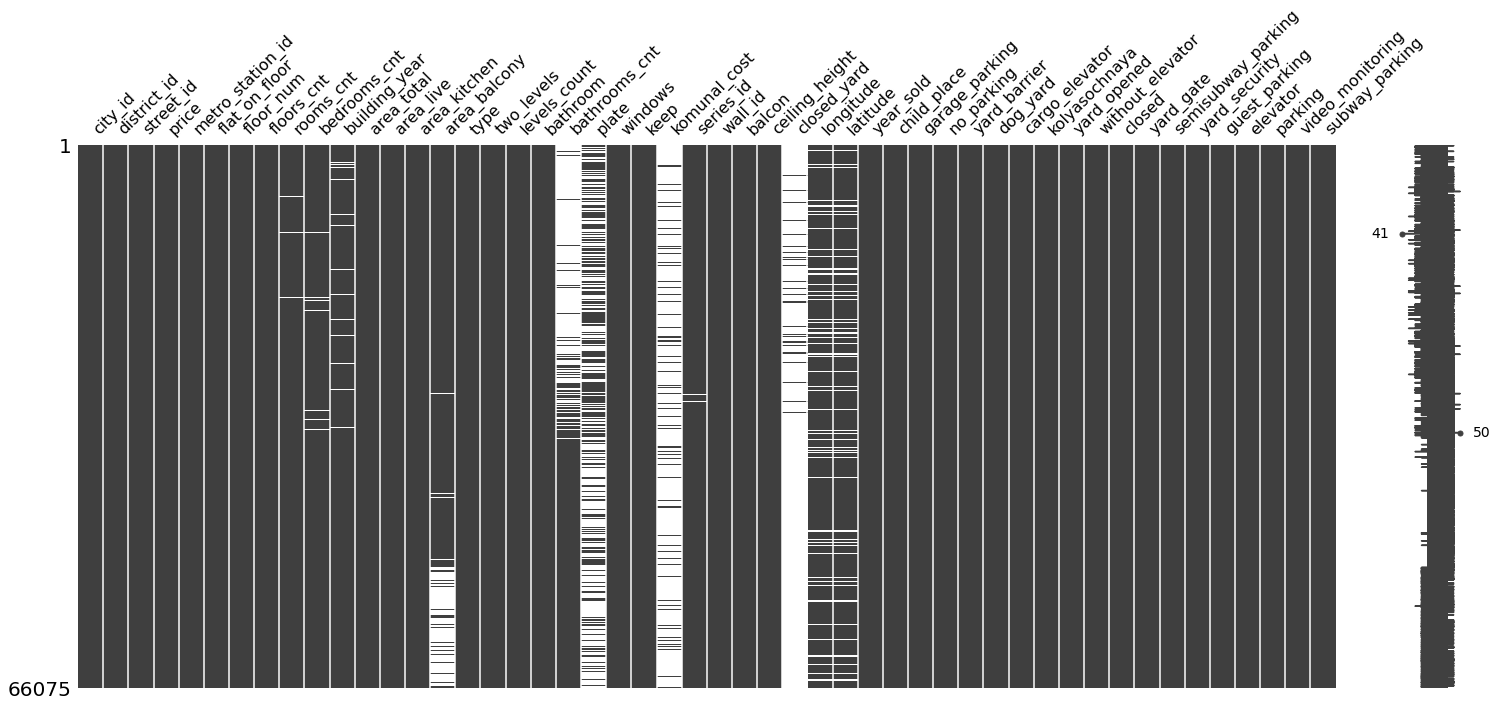

In [91]:
msn.matrix(data);
print('Процентное количество пропусков:\n')
(data.isna().sum()/len(data)*100).sort_values(ascending=False)

Признаки closed_yard, komunal_cost имееют слишком много пропусков (более 80 %), для дальнейшего использования они не подходят.

In [92]:
data.drop(columns=['closed_yard', 'komunal_cost'], inplace=True)

В признаке bathroom_cnt пропуски соответствую значению 1, согласно условиям задачи

In [93]:
data['bathrooms_cnt'].fillna(1, inplace=True)

In [94]:
# Выделим категориальные и числовые признаки

category_cols = [
    'city_id',
    'district_id',
    'metro_station_id',
    'type',
    'two_levels',
    'bathroom',
    'plate',
    'windows',
    'keep',
    'series_id',
    'wall_id',
    'balcon',
    'without_elevator',
    'kolyasochnaya',
    'elevator',
    'parking',
    'subway_parking',
    'video_monitoring',
    'yard_barrier',
    'garage_parking',
    'semisubway_parking',
    'yard_gate',
    'no_parking',
    'dog_yard',
    'closed',
    'yard_opened',
    'cargo_elevator',
    'child_place',
    'guest_parking',
    'yard_security'
]

num_cols = data.drop(columns=category_cols+['price']).columns.to_list()

### Категориальные признаки

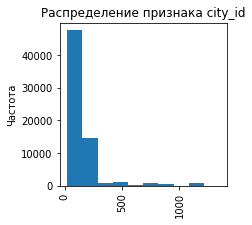

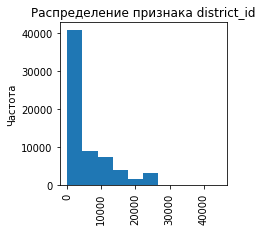

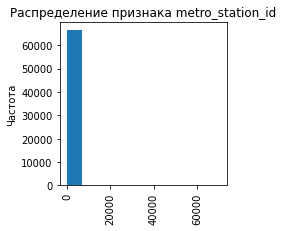

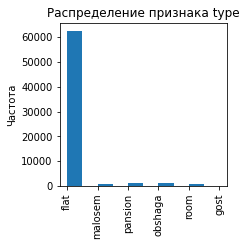

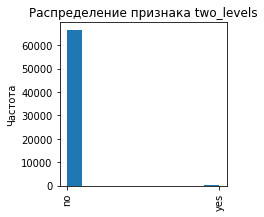

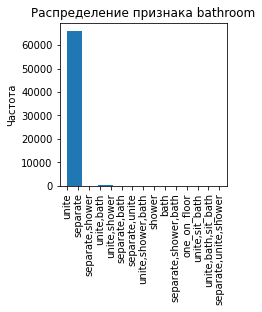

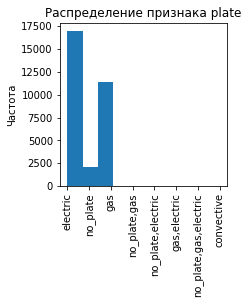

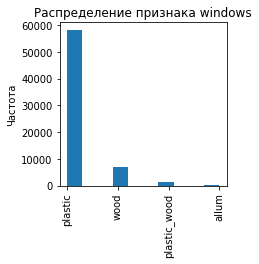

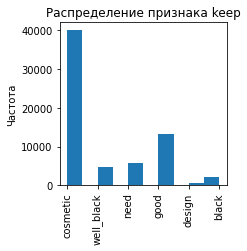

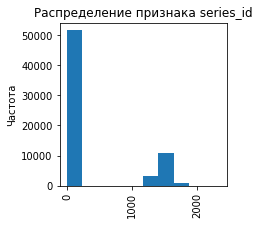

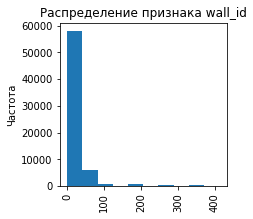

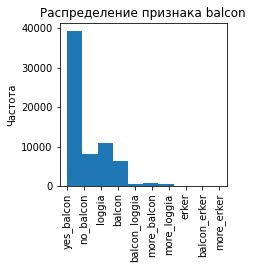

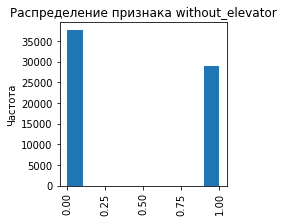

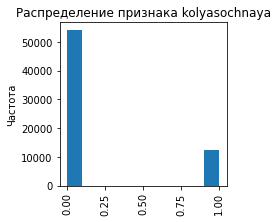

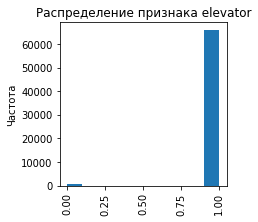

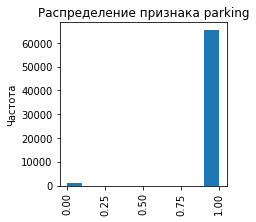

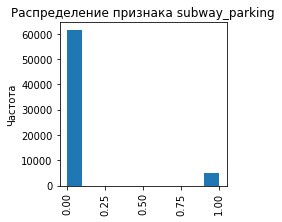

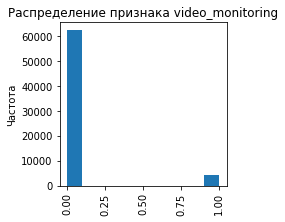

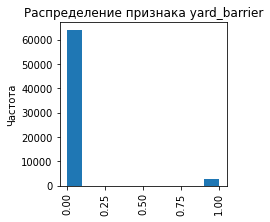

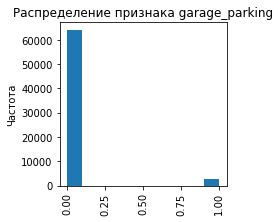

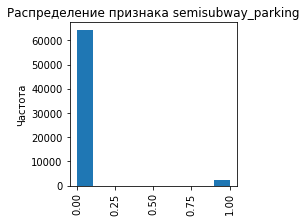

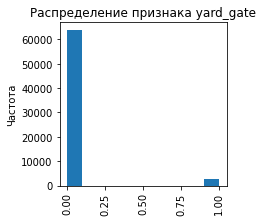

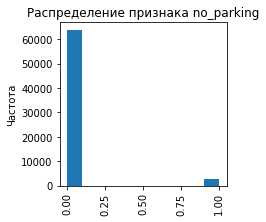

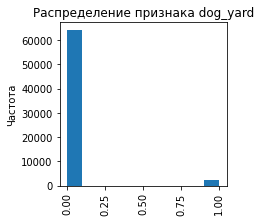

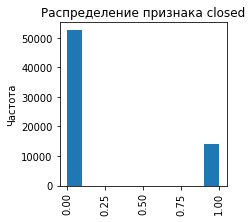

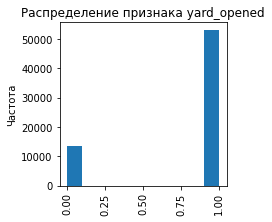

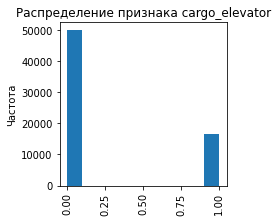

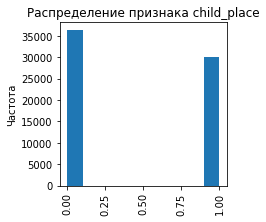

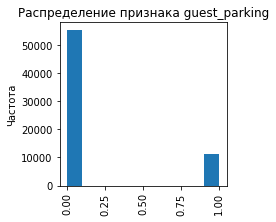

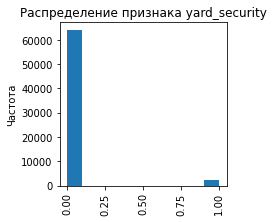

In [25]:
# Посмотрим на распределение категориальных признаков
for col in category_cols:
    plt.figure(figsize=(3, 3))
    plt.hist(data[col].dropna())
    plt.title(f'Распределение признака {col}')
    plt.ylabel('Частота')
    plt.xticks(rotation=90)

In [26]:
# Заполним пропуски в категориальных признаках самым частым значением
cat_imp = SimpleImputer(strategy='most_frequent')
data[category_cols] = cat_imp.fit_transform(data[category_cols].astype(str))

### Числовые признаки

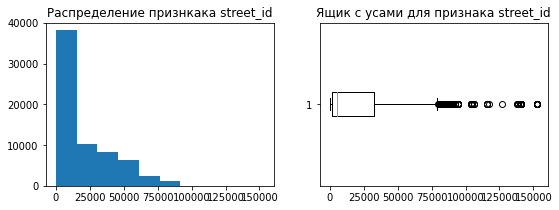

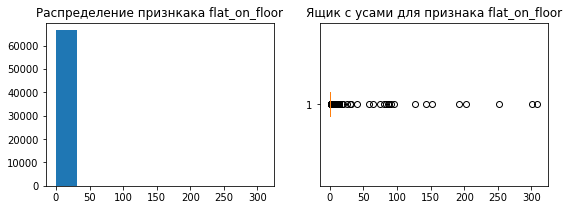

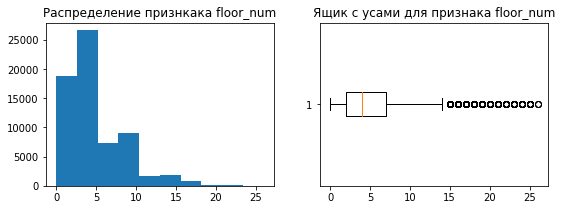

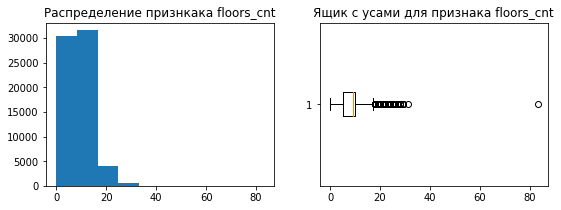

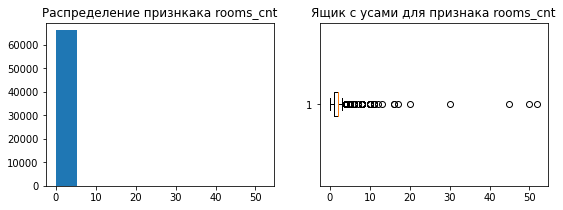

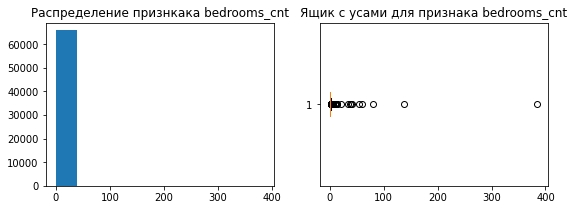

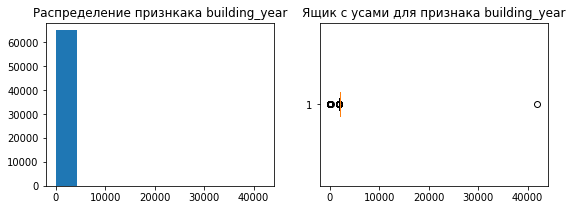

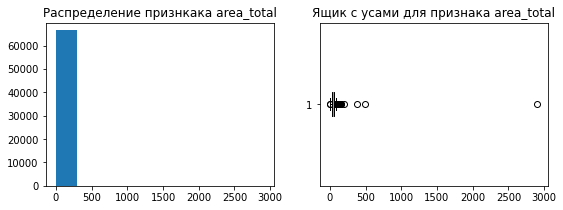

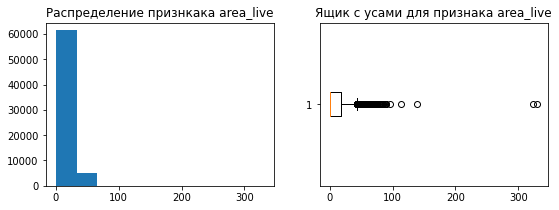

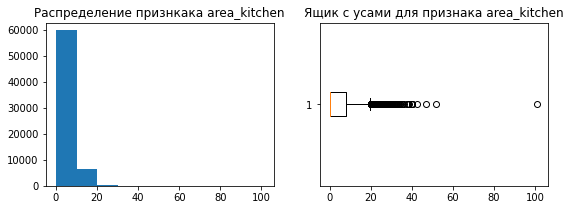

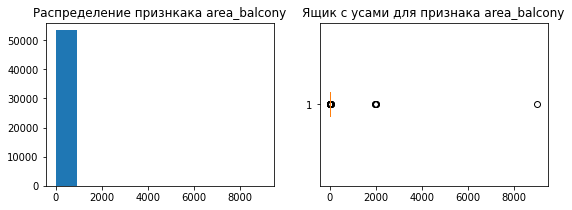

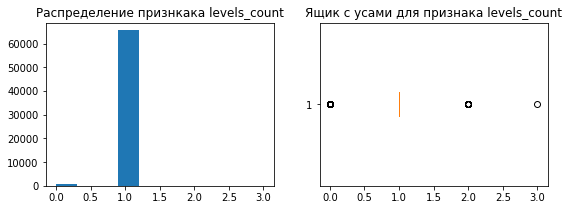

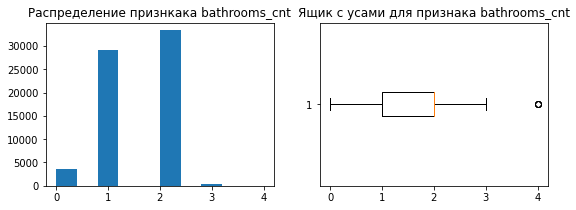

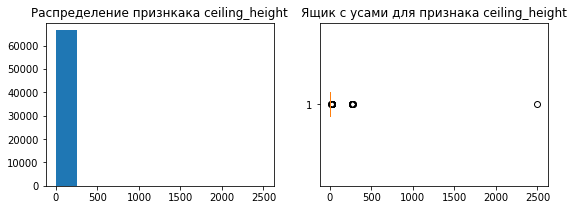

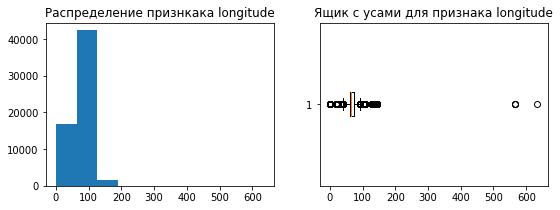

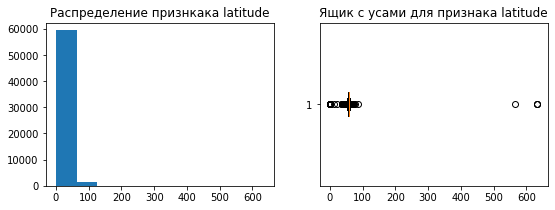

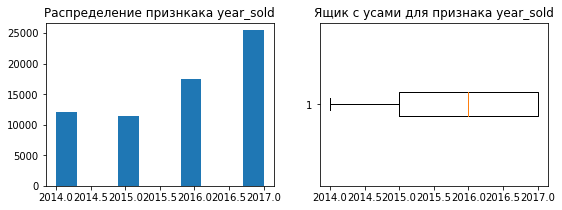

In [27]:
# Посмотрим на распределение числовых признаков
for col in num_cols:
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(9, 3))

    ax1.hist(data[col].dropna())
    ax1.set_title(f'Распределение признкака {col}')

    ax2.boxplot(data[col].dropna(), vert=False)
    ax2.set_title(f'Ящик с усами для признака {col}')

В некоторых числовых признаках есть аномальные значения

In [28]:
# Заполним пропуски в числовых признаках медианным значением
num_imp = SimpleImputer(strategy='median')
data[num_cols] = cat_imp.fit_transform(data[num_cols])

## Обработка выбросов

### building year

In [29]:
# Посмотрим на значения признаков building_year
sorted(data.building_year.unique())

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 17.0,
 19.0,
 47.0,
 53.0,
 62.0,
 68.0,
 70.0,
 71.0,
 76.0,
 80.0,
 85.0,
 89.0,
 91.0,
 101.0,
 168.0,
 1850.0,
 1860.0,
 1863.0,
 1868.0,
 1870.0,
 1876.0,
 1880.0,
 1887.0,
 1888.0,
 1889.0,
 1890.0,
 1892.0,
 1900.0,
 1903.0,
 1907.0,
 1910.0,
 1912.0,
 1913.0,
 1915.0,
 1916.0,
 1917.0,
 1918.0,
 1920.0,
 1922.0,
 1924.0,
 1925.0,
 1926.0,
 1927.0,
 1928.0,
 1929.0,
 1930.0,
 1931.0,
 1932.0,
 1933.0,
 1934.0,
 1935.0,
 1936.0,
 1937.0,
 1938.0,
 1939.0,
 1940.0,
 1941.0,
 1943.0,
 1944.0,
 1945.0,
 1946.0,
 1947.0,
 1948.0,
 1949.0,
 1950.0,
 1951.0,
 1952.0,
 1953.0,
 1954.0,
 1955.0,
 1956.0,
 1957.0,
 1958.0,
 1959.0,
 1960.0,
 1961.0,
 1962.0,
 1963.0,
 1964.0,
 1965.0,
 1966.0,
 1967.0,
 1968.0,
 1969.0,
 1970.0,
 1971.0,
 1972.0,
 1973.0,
 1974.0,
 1975.0,
 1976.0,
 1977.0,
 1978.0,
 1979.0,
 1980.0,
 1981.0,
 1982.0,
 1983.0,
 1984.0,
 1985.0,
 1986.0,
 1987.0,
 1988.0,
 1989.0,
 1990.0,
 1991.0,
 1992.0,
 1993.0,
 1994.0,
 1995.0,
 1996.0,

Обработаем значения, которые меньше 1850 или больше 2029, исходя из мысли, что недвижимость может быть куплена на этапе строительства

In [30]:
data['building_year'][data['building_year'] < 1850] = 1850
data['building_year'][data['building_year'] > 2029] = 2029

## Создание признаков

In [31]:
# Создадим признак data_diff - количество лет с момента
data['data_diff'] = data['year_sold'] - data['building_year']
num_cols.append('data_diff')

# Моделирование

In [32]:
# Разделим данные на тренировочную и тестовую выборки
X = data.drop(columns=['price'])
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

У некоторых категориальных признаков большое количество уникальных категорий. Для простоты интерпретации результатов категориальные признаки будем кодировать с помощью целевого кодирования (вместо горячего)

In [33]:
# Препроцессор категориальных признаков
cat_proc = Pipeline([
    ('coding', TargetEncoder()),
    ('scale', StandardScaler())
])

# Препроцессор числовых признаков
num_proc = Pipeline([
    ('scale', StandardScaler())
])

# Общий препроцессов
preprocessor = ColumnTransformer([
    ('cat', cat_proc, category_cols),
    ('num', num_proc, num_cols)
])

## Lasso

In [35]:
%%time
model = Lasso(random_state=42)
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

param_grid = {
    'model__alpha': [0.1, 0.5, 1, 10]
}

gs = GridSearchCV(
    estimator = pipe,
    param_grid=param_grid,
    scoring='r2',
    cv=4,
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)
best_pipe = gs.best_estimator_

print(f"Лучшая модели после тюнинга гиперпараметров: {best_pipe.named_steps['model']}")

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Лучшая модели после тюнинга гиперпараметров: Lasso(alpha=0.5, random_state=42)
CPU times: total: 5.78 s
Wall time: 21.9 s


In [36]:
%%time
# Обучим лучшую модель
best_pipe.fit(X_train, y_train)

# Расчитаем предсказания модели
y_train_pred = best_pipe.predict(X_train)
y_test_pred = best_pipe.predict(X_test)

# Расчитаем метрика качества модели
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'MAE на трейне: {mae_train}, MAE на тесте: {mae_test}')
print(f'r2 на трейне: {r2_train}, r2 на тесте: {r2_test}')

# Сохраним модель
with open('models/lasso.pkl', 'wb') as file:
    dill.dump(best_pipe, file)

MAE на трейне: 333.27257758013866, MAE на тесте: 334.2777088371183
r2 на трейне: 0.7521185269227701, r2 на тесте: 0.7820886394858566
CPU times: total: 4.2 s
Wall time: 3.73 s


## Ridge

In [37]:
%%time
model = Ridge(random_state=42)
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

param_grid = {
    'model__alpha': [0.1, 0.5, 1, 10]
}

gs = GridSearchCV(
    estimator = pipe,
    param_grid=param_grid,
    scoring='r2',
    cv=4,
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)
best_pipe = gs.best_estimator_

print(f"Лучшая модели после тюнинга гиперпараметров: {best_pipe.named_steps['model']}")

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Лучшая модели после тюнинга гиперпараметров: Ridge(alpha=10, random_state=42)
CPU times: total: 5.05 s
Wall time: 12.2 s


In [38]:
%%time
# Обучим лучшую модель
best_pipe.fit(X_train, y_train)

# Расчитаем предсказания модели
y_train_pred = best_pipe.predict(X_train)
y_test_pred = best_pipe.predict(X_test)

# Расчитаем метрика качества модели
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'MAE на трейне: {mae_train}, MAE на тесте: {mae_test}')
print(f'r2 на трейне: {r2_train}, r2 на тесте: {r2_test}')

# Сохраним модель
with open(f'models/ridge.pkl', 'wb') as file:
    dill.dump(best_pipe, file)

MAE на трейне: 333.31346378473256, MAE на тесте: 334.42594380662274
r2 на трейне: 0.7521347749198983, r2 на тесте: 0.7819450846492356
CPU times: total: 2.97 s
Wall time: 3.03 s


## KNN

In [39]:
%%time
model = KNeighborsRegressor()
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

param_grid = {
    'model__weights': ['uniform', 'distance'],
    'model__n_neighbors': [3, 5, 7, 10, 20]
}

gs = GridSearchCV(
    estimator = pipe,
    param_grid=param_grid,
    scoring='r2',
    cv=4,
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)
best_pipe = gs.best_estimator_

print(f"Лучшая модели после тюнинга гиперпараметров: {best_pipe.named_steps['model']}")

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Лучшая модели после тюнинга гиперпараметров: KNeighborsRegressor(n_neighbors=10, weights='distance')
CPU times: total: 9.06 s
Wall time: 1min 2s


In [40]:
%%time
# Обучим лучшую модель
best_pipe.fit(X_train, y_train)

# Расчитаем предсказания модели
y_train_pred = best_pipe.predict(X_train)
y_test_pred = best_pipe.predict(X_test)

# Расчитаем метрика качества модели
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'MAE на трейне: {mae_train}, MAE на тесте: {mae_test}')
print(f'r2 на трейне: {r2_train}, r2 на тесте: {r2_test}')

# Сохраним модель
with open(f'models/knn.pkl', 'wb') as file:
    dill.dump(best_pipe, file)

MAE на трейне: 0.018855078061899955, MAE на тесте: 350.6626416842023
r2 на трейне: 0.9999983639497315, r2 на тесте: 0.7509151207588883
CPU times: total: 28.7 s
Wall time: 9.15 s


## RandomForest

In [41]:
%%time
model = RandomForestRegressor(random_state=42)
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 15, 20],
}

gs = GridSearchCV(
    estimator = pipe,
    param_grid=param_grid,
    scoring='r2',
    cv=4,
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)
best_pipe = gs.best_estimator_

print(f"Лучшая модели после тюнинга гиперпараметров: {best_pipe.named_steps['model']}")

Fitting 4 folds for each of 9 candidates, totalling 36 fits
Лучшая модели после тюнинга гиперпараметров: RandomForestRegressor(max_depth=20, n_estimators=300, random_state=42)
CPU times: total: 4min 27s
Wall time: 19min 22s


In [42]:
%%time
# Обучим лучшую модель
best_pipe.fit(X_train, y_train)

# Расчитаем предсказания модели
y_train_pred = best_pipe.predict(X_train)
y_test_pred = best_pipe.predict(X_test)

# Расчитаем метрика качества модели
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'MAE на трейне: {mae_train}, MAE на тесте: {mae_test}')
print(f'r2 на трейне: {r2_train}, r2 на тесте: {r2_test}')

# Сохраним модель
with open(f'models/rfc.pkl', 'wb') as file:
    dill.dump(best_pipe, file)

MAE на трейне: 97.57426386237172, MAE на тесте: 221.13142051840026
r2 на трейне: 0.9810550879574899, r2 на тесте: 0.8914906829068446
CPU times: total: 4min 37s
Wall time: 4min 43s


## XGBoost

In [43]:
%%time
model = XGBRegressor(random_state=42)
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

param_grid = {
    'model__n_estimators': [100, 175, 250],
    'model__max_depth': [3, 4, 5],
    'model__alpha': [0.1, 0.5, 1]
}

gs = GridSearchCV(
    estimator = pipe,
    param_grid=param_grid,
    scoring='r2',
    cv=4,
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)
best_pipe = gs.best_estimator_

print(f"Лучшая модели после тюнинга гиперпараметров: {best_pipe.named_steps['model']}")

Fitting 4 folds for each of 27 candidates, totalling 108 fits
Лучшая модели после тюнинга гиперпараметров: XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)
CPU times: total: 47.9 s
Wall time: 5min 57s


In [44]:
%%time
# Обучим лучшую модель
best_pipe.fit(X_train, y_train)

# Расчитаем предсказания модели
y_train_pred = best_pipe.predict(X_train)
y_test_pred = best_pipe.predict(X_test)

# Расчитаем метрика качества модели
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'MAE на трейне: {mae_train}, MAE на тесте: {mae_test}')
print(f'r2 на трейне: {r2_train}, r2 на тесте: {r2_test}')

# Сохраним модель
with open(f'models/xgb.pkl', 'wb') as file:
    dill.dump(best_pipe, file)

MAE на трейне: 160.67215360211122, MAE на тесте: 201.97106405625644
r2 на трейне: 0.9495569850768669, r2 на тесте: 0.9113464073901172
CPU times: total: 30.5 s
Wall time: 10.1 s


## CatBoost

In [45]:
%%time
model = CatBoostRegressor(random_state=42, verbose=False)
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

param_grid = {
    'model__depth': [3, 4, 5],
    'model__iterations': [100, 200, 350]
}

gs = GridSearchCV(
    estimator = pipe,
    param_grid=param_grid,
    scoring='r2',
    cv=4,
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)
best_pipe = gs.best_estimator_

print(f"Лучшая модели после тюнинга гиперпараметров: {best_pipe.named_steps['model']}")

Fitting 4 folds for each of 9 candidates, totalling 36 fits
Лучшая модели после тюнинга гиперпараметров: <catboost.core.CatBoostRegressor object at 0x0000020D60A2C220>
CPU times: total: 19.4 s
Wall time: 58.6 s


In [46]:
%%time
# Обучим лучшую модель
best_pipe.fit(X_train, y_train)

# Расчитаем предсказания модели
y_train_pred = best_pipe.predict(X_train)
y_test_pred = best_pipe.predict(X_test)

# Расчитаем метрика качества модели
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'MAE на трейне: {mae_train}, MAE на тесте: {mae_test}')
print(f'r2 на трейне: {r2_train}, r2 на тесте: {r2_test}')

# Сохраним модель
with open(f'models/catboost.pkl', 'wb') as file:
    dill.dump(best_pipe, file)

MAE на трейне: 195.95230116954951, MAE на тесте: 208.7911273088649
r2 на трейне: 0.9220560063767228, r2 на тесте: 0.9066978029478734
CPU times: total: 14 s
Wall time: 5.69 s


## Voting

Построим модель голосования на наиболее сильных моделях

In [47]:
with open(f'models/xgb.pkl', 'rb') as file:
    xgb = dill.load(file).named_steps['model']

with open(f'models/catboost.pkl', 'rb') as file:
    catboost = dill.load(file).named_steps['model']

model = VotingRegressor(estimators=[
    ('xgb', xgb),
    ('catboost', catboost)
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

In [48]:
%%time
# Обучим лучшую модель
pipe.fit(X_train, y_train)

# Расчитаем предсказания модели
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

# Расчитаем метрика качества модели
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'MAE на трейне: {mae_train}, MAE на тесте: {mae_test}')
print(f'r2 на трейне: {r2_train}, r2 на тесте: {r2_test}')

# Сохраним модель
with open('models/vote.pkl', 'wb') as file:
    dill.dump(pipe, file)

MAE на трейне: 172.99358253199497, MAE на тесте: 199.70447416706048
r2 на трейне: 0.9403780783500756, r2 на тесте: 0.9135834466772851
CPU times: total: 43.1 s
Wall time: 13.2 s


## Выбор итоговой модели

In [49]:
model_names = []
r2_test = []
mae_test = []

models = os.listdir(f'models')
for model in models:
    with open(f'models/{model}', 'rb') as file:
        pipe = dill.load(file)
    model_names.append(type(pipe.named_steps['model']).__name__)
    y_pred = pipe.predict(X_test)
    r2_test.append(r2_score(y_test, y_pred))
    mae_test.append(mean_absolute_error(y_test, y_pred))

In [52]:
results = pd.DataFrame({
    'R2': r2_test,
    'MAE': mae_test
}, index=model_names)
results.sort_values(by='R2', ascending=False)

,R2,MAE
VotingRegressor,0.913583,199.704474
XGBRegressor,0.911346,201.971064
CatBoostRegressor,0.906698,208.791127
RandomForestRegressor,0.891491,221.131421
Lasso,0.782089,334.277709
Ridge,0.781945,334.425944
KNeighborsRegressor,0.750915,350.662642


***Лучшую метрику r2 и mae имеет модель голосования, построенная на моделях xgboost и catboost***

# Оценка важности признаков

Посмотрим на важность признаков с помощью SHAP диаграммы и одной из лучших расcмотренных моделей (xgboost)

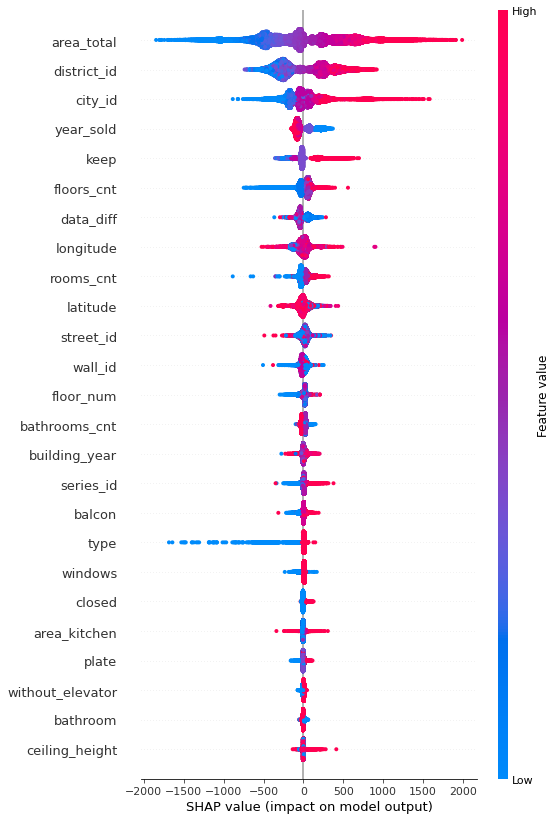

In [117]:
with open(f'models/xgb.pkl', 'rb') as file:
    xgb = dill.load(file).named_steps['model']

df = X_train.copy()
df[category_cols] = TargetEncoder().fit_transform(df[category_cols], y_train)
xgb.fit(df, y_train)

shap_test = shap.TreeExplainer(xgb).shap_values(df)
shap.summary_plot(shap_test, df,
                      max_display=25, auto_size_plot=True)

С помощью данной диаграммы можно интерпретировать важности признаков, например:
1. Самым важным признаком является общая площадь объекта. Высокие значения площади соотвествую высоким значениям цены и наоборот - низкие площади соответсвуют низким значениям цены.
2. Цена сильно зависит от улицы, на которой расположен объект.
3. Интересный результат - чем раньше был продан объект, тем выше была его цена.
4. Чем больше этажей в объекте недвижимости, тем выше цена.
5. Чем больше комнат в объекте недвижимости, тем выше цена.

# Создание пайплайна обработки данных

Итоговвый пайплайн строится с учетом следующих предположений:
1. Признак price - целевая переменная
2. Признак sold_price отсутсвует
3. Используются данные без аномальновысоких значений стоимости

In [118]:
# Функция отбора признаков
def feature_selection(data_in):
    data_out = data_in.copy()
    drop_cols = [
        'id',
        'status',
        'loggia',
        'builder_id',
        'closed_yard',
        'komunal_cost'
    ]
    data_out.drop(columns=drop_cols, inplace=True)
    return data_out

In [119]:
# Функция обработки признака area_balcony
def balcony_process(data_in):
    def func(d):
        if re.search('\d+[.,]?\d*', d):
            return re.search('\d+[.,]?\d*', d).group()
        else:
            return np.nan

    data_out = data_in.copy()
    data_out['area_balcony'] = data_out['area_balcony'].astype(str).apply(func)
    data_out['area_balcony'] = data_out['area_balcony'].str.replace(',', '.')

    return data_out

In [120]:
# Функция обработки признака territory
def territory_process(data_in):
    data_out = data_in.copy()
    data_ter = data_out['territory'].dropna().unique()
    data_ter = [
        'parking',
        'dog_yard',
        'yard_gate',
        'child_place',
        'closed',
        'garage_parking',
        'video_monitoring',
        'yard_barrier',
        'semisubway_parking',
        'subway_parking',
        'cargo_elevator',
        'kolyasochnaya',
        'no_parking',
        'yard_opened',
        'yard_security',
        'elevator',
        'guest_parking',
        'without_elevator'
    ]
    for s in data_ter:
        ind = data['territory'].isna()
        data_out[s] = data_out['territory'][~ind]
        data_out[s] = data_out[s][~ind].apply(lambda d: s in d if d else np.nan)
    data_out.drop(columns=['territory'], inplace=True)
    return data_out

In [121]:
# Функция изменения типов данных
def change_dtypes(data_in):
    import pandas as pd

    # Преобзование даты продажи к типу datetime
    data_out = data_in.copy()
    data_out['date_sold'] = pd.to_datetime(data_out['date_sold'])
    data_out['year_sold'] = data_out['date_sold'].dt.year
    data_out.drop(columns=['date_sold'], inplace=True)

    # Преобразование целочисленных данных к целочисленному типу
    cols_to_int = [
        'metro_station_id',
        'floor_num',
        'floors_cnt',
        'rooms_cnt',
        'bedrooms_cnt',
        'building_year',
        'bathrooms_cnt',
        'series_id',
        'wall_id'
        ]
    cols_to_bool = [
            'parking',
            'dog_yard',
            'yard_gate',
            'child_place',
            'closed',
            'garage_parking',
            'video_monitoring',
            'yard_barrier',
            'semisubway_parking',
            'subway_parking',
            'cargo_elevator',
            'kolyasochnaya',
            'no_parking',
            'yard_opened',
            'yard_security',
            'elevator',
            'guest_parking',
            'without_elevator']
    data_out[cols_to_int] = data_out[cols_to_int].astype(pd.Int64Dtype())
    data_out[cols_to_bool] = data_out[cols_to_bool].astype(bool).astype(pd.Int64Dtype())

    # Преобразование данных к вещественному типу
    data_out['area_balcony'] = data_out['area_balcony'].astype(float)
    return data_out

In [122]:
# Функция обработки признака building_year и создания data_diff
def data_diff_gen(data_in):
    data_out = data_in.copy()
    data_out['building_year'][data_out['building_year'] < 1850] = 1850
    data_out['building_year'][data_out['building_year'] > 2029] = 2029
    data_out['data_diff'] = data_out['year_sold'] - data_out['building_year']
    return data_out

In [123]:
# Числовые признаки
num_cols = [
    'flat_on_floor',
    'floor_num',
    'floors_cnt',
    'rooms_cnt',
    'bedrooms_cnt',
    'building_year',
    'area_total',
    'area_live',
    'area_kitchen',
    'area_balcony',
    'levels_count',
    'bathrooms_cnt',
    'ceiling_height',
    'longitude',
    'latitude',
    'year_sold',
    'data_diff'
]

# Категориальные признаки
category_cols = [
    'city_id',
    'district_id',
    'street_id',
    'metro_station_id',
    'type',
    'two_levels',
    'bathroom',
    'plate',
    'windows',
    'keep',
    'series_id',
    'wall_id',
    'balcon',
    'parking',
    'dog_yard',
    'yard_gate',
    'child_place',
    'closed',
    'garage_parking',
    'video_monitoring',
    'yard_barrier',
    'semisubway_parking',
    'subway_parking',
    'cargo_elevator',
    'kolyasochnaya',
    'no_parking',
    'yard_opened',
    'yard_security',
    'elevator',
    'guest_parking',
    'without_elevator'
]

In [124]:
def bathroom_cnt_fillna(data_in):
    data_out = data_in.copy()
    data_out['bathrooms_cnt'].fillna(1, inplace=True)
    return data_out

In [125]:
# Препроцессор для числовых признаков
numeric_processor = SimpleImputer(strategy='median')

In [126]:
def sup_func(data_in):
    return data_in.astype(str)

# Препроцессор для категориальных признаков
category_processor = Pipeline([
    ('sup_func', FunctionTransformer(sup_func)),
    ('fiilna', SimpleImputer(strategy='most_frequent')),
    ('coding', TargetEncoder())
])

In [127]:
# Общий препроцессор
preprocessor = ColumnTransformer([
    ('numeric', numeric_processor, num_cols),
    ('category', category_processor, category_cols)
])

In [128]:
scaler = StandardScaler()

In [129]:
# Загрузим финальную модель
with open('models/vote.pkl', 'rb') as file:
    regressor = dill.load(file).named_steps['model']

In [131]:
# Создадим финальный пайплайн
final_pipe = Pipeline([
    ('feature_selection', FunctionTransformer(feature_selection)),
    ('balcony_process', FunctionTransformer(balcony_process)),
    ('territory_process', FunctionTransformer(territory_process)),
    ('change_dtypes', FunctionTransformer(change_dtypes)),
    ('data_diff_gen', FunctionTransformer(data_diff_gen)),
    ('bathroom_cnt_fillna', FunctionTransformer(bathroom_cnt_fillna)),
    ('preprocessor', preprocessor),
    ('scale', scaler),
    ('regressor', regressor)
])

final_pipe

Pipeline(steps=[('feature_selection',
                 FunctionTransformer(func=<function feature_selection at 0x0000020D8349D630>)),
                ('balcony_process',
                 FunctionTransformer(func=<function balcony_process at 0x0000020D5FEF3490>)),
                ('territory_process',
                 FunctionTransformer(func=<function territory_process at 0x0000020D8403E950>)),
                ('change_dtypes',
                 FunctionTransformer(func=<functio...
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=5,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           n_estimators=250,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           predictor=None, ...)),
                                             ('catboost',
                                              <catboost.core.CatBoostRegressor object at 0x0000020D83FDE560>)]))])

Посмотрим на работу итогового пайплайна

In [132]:
# Загрузим данные
data = pd.read_csv(f'data/sold_flats_2020-09-30.csv')
for col in ['price', 'sold_price']:
    q25, q75 = data[col].quantile([0.25, 0.75])
    iqi = (q25 - 1.5*(q75-q25), q75 + 1.5*(q75-q25))
    ind = (data[col] >= iqi[0]) & (data[col] <= iqi[1])
    data = data[ind]

X = data.drop(columns=['price', 'sold_price'])
y = data['price']

In [133]:
# Найдем метрики финального пайплайна
final_pipe.fit(X, y)
y_pred = final_pipe.predict(X)
print(f'r2_score на обученной модели: {r2_score(y, y_pred)}')
print(f'MAE на обученной модели: {mean_absolute_error(y, y_pred)}')

r2_score на обученной модели: 0.9401418018904453
MAE на обученной модели: 173.73413120773495


In [134]:
# Сохраним финальный пайплайн
with open('final_pipe.pkl', 'wb') as file:
    dill.dump(final_pipe, file)